In [186]:
import numpy as np
import numpy.random as npr
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import math

In [56]:
#law=pd.read_csv("/Users/antoinegrelety/Documents/ENSAE/S2_Bootstrap/TP1/lsat.dat")
law=pd.read_table("/Users/antoinegrelety/Documents/ENSAE/S2_Bootstrap/TP1/lsat.dat",sep=" ")

In [57]:
law.head()

,LSAT,GPA
0,576,3.39
1,635,3.30
2,558,2.81
3,578,3.03
4,666,3.44


In [35]:
n=law.shape[0]

In [59]:
LSAT=np.array(law["LSAT"])
GPA=np.array(law["GPA"])

In [60]:
law=np.array(law)

### Estimateur bootstrap de la variance de la corrélation

In [61]:
ind=npr.randint(0,n,15)
print(ind)

[ 4  9 10 10  6  1 14 14 10 13  0  7 12  8  3]


In [62]:
sample=law[ind,:]

In [63]:
np.correlate(LSAT,GPA)

array([ 27969.06])

In [79]:
B=200
corr_star=np.zeros(B)
for b in range(B):
    ind=npr.randint(0,n,15)
    sample_b=law[ind,:]
    corr_star[b]=np.corrcoef(LSAT[ind],GPA[ind])[0,1]
    #print(corr_star[b])

In [80]:
print("estimateur bootstrap:",np.var(corr_star))

estimateur bootstrap: 0.0151738033795


### Médiane

In [146]:
#Z_size=[100,1000,10000]
Z_size=[10]
B=10000

for c in Z_size:
    Z=npr.exponential(size=c)
    med_star=np.zeros(B)
    med=np.zeros(B)
    for b in range(B):
        ind=npr.randint(0,len(Z),len(Z))
        sample_b=Z[ind]
        med_star[b]=np.median(sample_b)
    print(np.var(med_star))

0.24323424919


### Estimation de la fonction de répartition

In [139]:
Z=npr.exponential(size=10)
med_Z=np.median(Z)

Fonction de répartition de la médiane empirique

In [113]:
M=10000
med_MC=np.zeros(M)
for m in range(M):
        Z=npr.exponential(size=10)
        med_MC[m]=np.median(Z)
print("médiane via MC:",np.mean(med_MC))

médiane via MC: 0.747642864594


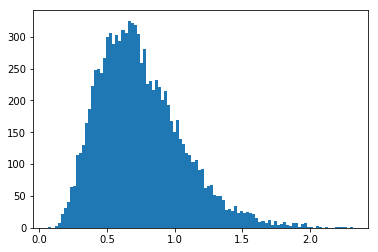

In [114]:
plt.hist(med_MC,bins=100)
plt.show()

In [128]:
med_MC.shape

(10000,)

Fonction de répartition de l'approximation asymptotique gaussienne

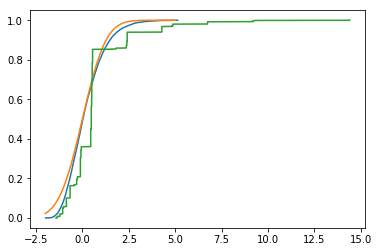

In [158]:
plt.plot(np.sqrt(len(Z))*(np.sort(med_MC)-np.log(2)),(1/M)*np.arange(M))
gridnorm=np.arange(-2,5,0.01)
plt.plot(gridnorm,norm.cdf(gridnorm))
plt.plot(np.sqrt(len(Z))*(np.sort(med_star)-med_Z),(1/B)*np.arange(B))
plt.show()

## Partie 2: intervalles de confiance

In [226]:
n=10
p=0.7
theta=0.007
q=1
kappa=0.02
alpha=0.05
tau=(p*kappa)/(q*theta)

In [227]:
X=npr.gamma(p,1/theta,size=n)
Y=npr.gamma(q,1/kappa,size=n)

In [228]:
def tau_hat(x,y):
    return(np.mean(x)/np.mean(y))

### IC par bootstrap

In [229]:
def sigma_hat(x,y):
    return  np.sqrt( np.var(x)/(np.mean(y**2)) + (np.mean(x**2)/np.mean(y**4))*np.var(y) )

In [230]:
def ICAN(alpha,X,Y):
    A= []
    A.append(tau_hat(X,Y)-sigma_hat(X,Y)/np.sqrt(n)*norm.ppf(1-alpha/2))
    A.append(tau_hat(X,Y)+sigma_hat(X,Y)/np.sqrt(n)*norm.ppf(1-alpha/2))
    return A

In [231]:
print(ICAN(alpha,X,Y))
print(tau_hat(X,Y))

[0.8928674744209133, 3.2859831169301472]
2.08942529568


In [255]:
#Bootstrap
B=1000
tau_star=np.zeros(B)
S_star=np.zeros(B)
tau_hat_val=tau_hat(X,Y)
for b in range(B):
    ind=npr.randint(0,n,n)
    sample_X=X[ind]
    sample_Y=Y[ind]
    tau_star[b]=tau_hat(sample_X,sample_Y)
    var_hat=np.var(sample_X/np.sqrt(np.var(sample_X)/np.mean(sample_Y)**2+
                                    np.mean(sample_X)*np.var(sample_Y)/np.mean(sample_Y)**4) )
    S_star[b]=np.sqrt(n)*(tau_star[b]-tau_hat_val)/np.sqrt(var_hat)

#ordonne les paramètres estimés
tau_star=np.sort(tau_star)
S_star=np.sort(S_star)

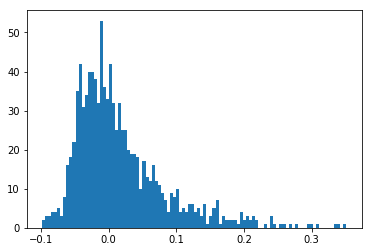

In [256]:
plt.hist(S_star,bins=100)
plt.show()

In [233]:
def IC_base(alpha,x,y,theta):
    A= []
    A.append( 2*tau_hat(x,y)-theta[math.ceil(len(theta)*(1-alpha/2))] )
    A.append( 2*tau_hat(x,y)-theta[math.ceil(len(theta)*(alpha/2))] )
    return(A)

In [234]:
print("Intervalle de confiance de base:",IC_base(alpha,X,Y,tau_star))

Intervalle de confiance de base: [-0.18357523647229002, 3.2533204385723882]


In [235]:
def IC_perc(alpha,x,y,theta):
    A= []
    A.append( theta[math.ceil(len(theta)*(alpha/2))] )
    A.append( theta[math.ceil(len(theta)*(1-alpha/2))] )
    return(A)

In [236]:
print("Intervalle de confiance percentile:",IC_perc(alpha,X,Y,tau_star))

Intervalle de confiance percentile: [0.92553015277867201, 4.3624258278233503]


In [257]:
def IC_t_boot(alpha,x,y,theta):
    A= []
    sigma_F=np.sqrt( np.var(x/np.sqrt(np.var(x)/np.mean(y)**2+
                                    np.mean(x)*np.var(y)/np.mean(y)**4) ) )
    
    A.append( tau_hat(x,y) - sigma_F*theta[math.ceil(len(theta)*(1-alpha/2))]/np.sqrt(n) )
    A.append( tau_hat(x,y) - sigma_F*theta[math.ceil(len(theta)*(alpha/2))]/np.sqrt(n)  )
    return(A)

In [259]:
print("Intervalle de confiance t-bootstrap:",IC_t_boot(alpha,X,Y,S_star))

Intervalle de confiance t-bootstrap: [-1.3882196612655919, 3.2263538431377334]


In [ ]:
def bornes_sup_inf():
    IC1=IC_base(alpha,X,Y,tau_star)
    IC2=IC_perc(alpha,X,Y,tau_star)
    IC3=IC_t_boot(alpha,X,Y,S_star)
    return([,])